In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
import pathlib
data_dir='/content/drive/MyDrive/AutismDataset/train'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/AutismDataset/train')

In [5]:
len(list(data_dir.glob('*.jpg')))

2540

In [6]:
autistic=list(data_dir.glob('Autistic*'))

In [7]:
len(autistic)

1270

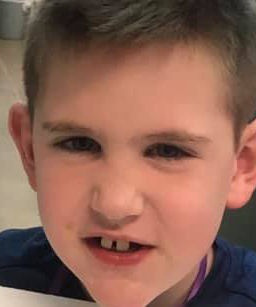

In [8]:
Image.open(str(autistic[3]))

In [9]:
nonautistic=list(data_dir.glob('Non_Autistic*'))
len(nonautistic)

1270

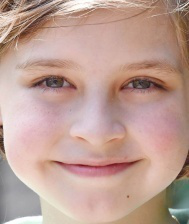

In [10]:
Image.open(str(nonautistic[3]))

In [11]:
images_dic={'autistic':list(data_dir.glob('Autistic*')),'nonautistic':list(data_dir.glob('Non_Autistic*'))}
labels_dic={'autistic':0,'nonautistic':1}

In [12]:
# images_dic['autistic']

In [13]:
X_train, y_train = [], []

for name, images in images_dic.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X_train.append(resized_img)
        y_train.append(labels_dic[name])

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [15]:
X_train.shape

(2540, 224, 224, 3)

In [16]:
X_train_scaled = X_train / 255


In [17]:
data_dir_test='/content/drive/MyDrive/AutismDataset/test'
data_dir_test= pathlib.Path(data_dir_test)
data_dir_test

PosixPath('/content/drive/MyDrive/AutismDataset/test')

In [18]:
images_dic_test={'autistic':list(data_dir_test.glob('Autistic*')),'nonautistic':list(data_dir_test.glob('Non_Autistic*'))}
labels_dic_test={'autistic':0,'nonautistic':1}

In [19]:
X_test, y_test = [], []
for name, images in images_dic_test.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X_test.append(resized_img)
        y_test.append(labels_dic[name])
X_test=np.array(X_test)
y_test=np.array(y_test)

In [20]:
predicted = classifier.predict(np.array([X_train[0],X_train[1],X_train[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 795, 795])

In [21]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [22]:
num_of_classes = 2

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
X_train_scaled.shape

(2540, 224, 224, 3)

In [24]:
model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
80/80 [==============================] - 12s 86ms/step - loss: 0.5657 - acc: 0.7008
Epoch 2/5
80/80 [==============================] - 6s 81ms/step - loss: 0.4593 - acc: 0.7772
Epoch 3/5
80/80 [==============================] - 6s 80ms/step - loss: 0.4370 - acc: 0.7898
Epoch 4/5
80/80 [==============================] - 6s 80ms/step - loss: 0.4082 - acc: 0.8071
Epoch 5/5
80/80 [==============================] - 6s 81ms/step - loss: 0.3857 - acc: 0.8236


In [25]:
X_test_scaled=X_test/255
y_test_scaled=y_test/255

In [26]:
model.evaluate(X_test_scaled,y_test)

10/10 [==============================] - 1s 75ms/step - loss: 0.4178 - acc: 0.7867


[0.4177987575531006, 0.7866666913032532]

In [27]:
def predicts(model,x):
  x = cv2.imread(x)
  resized_img = cv2.resize(x,(224,224))
  x_pre=np.array(resized_img).reshape((1,224,224,3))
  predictions=model(x_pre)
  predicted = np.argmax(predictions, axis=1)
  return predicted

In [28]:
def detect_human(path):
    count=0
    face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") 
    img = cv2.imread(path)
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray_img, scaleFactor=1.05,minNeighbors=5)
    for x, y, w, h in faces:
        img=cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
        count+=1
    resized=cv2.resize(img,(int(img.shape[1]/3), int(img.shape[0]/3)))
    return count


In [38]:
if __name__=="__main__":
  path_of_image=input("Enter Path of image/file name to detect for autism : ")  
  if(detect_human(path_of_image)>0):
    if(predicts(model,path_of_image)==1):
      print("Non Autistic")
    else:
      print("Autistic")
  else:
    print("Image given doesnt have a face to proceed to detect for autism")

Enter Path of image/file name to detect for autism : Non_Auti_1.jpg
Non Autistic
